In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings

In [2]:
warnings.simplefilter("ignore", category=UserWarning)

# Download data
ticker = 'AAPL'
date_start = '2020-01-01'
date_end = '2024-12-31'
df = yf.download(ticker, start=date_start, end=date_end, auto_adjust=True)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate returns
df['Return'] = df['Close'].pct_change()
df.drop(['High', 'Low', 'Open', 'Volume'], axis=1, inplace=True)
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


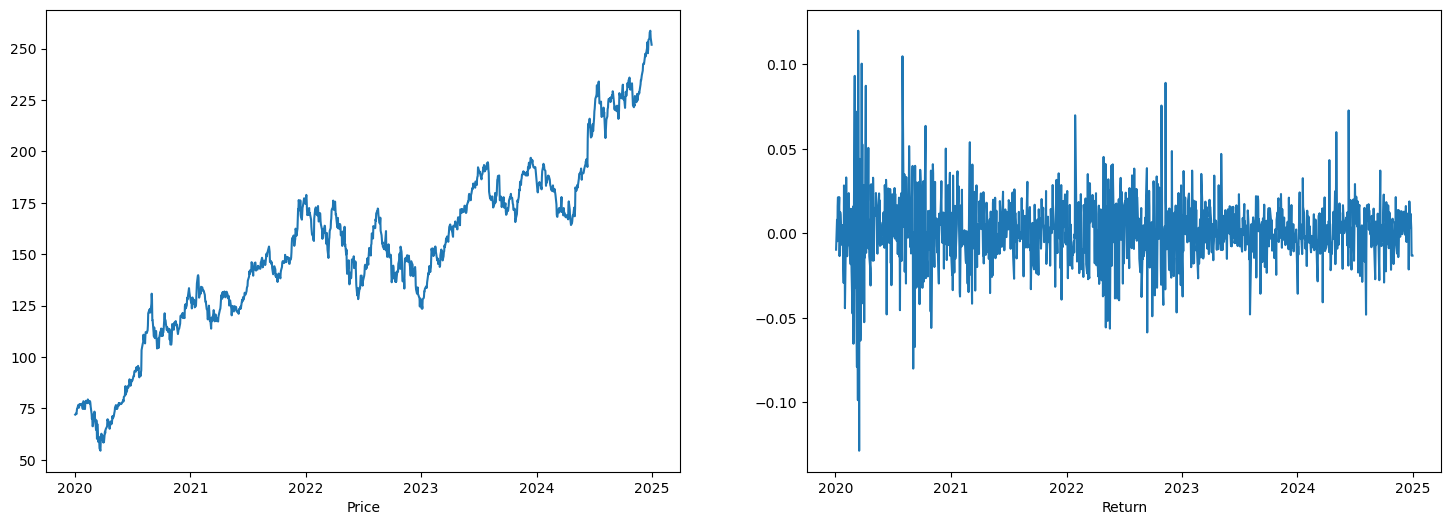

In [3]:
# Visualize stock price
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.plot(df['Close'])
plt.xlabel('Price')
plt.subplot(1,2,2)
plt.plot(df['Return'])
plt.xlabel('Return')
plt.show()

In [4]:
# Function to check stationarity
def check_stationarity(series, alpha=0.05):
    series = series.dropna()

    # ADF Test (Null Hypothesis: Series is non-stationary)
    adf_pvalue = adfuller(series)[1]
    adf_stationary = adf_pvalue < alpha

    # KPSS Test (Null Hypothesis: Series is stationary)
    kpss_pvalue = kpss(series)[1]
    kpss_stationary = kpss_pvalue > alpha

    print(f"ADF Test p-value: {adf_pvalue:.4f} -> Stationary: {adf_stationary}")
    print(f"KPSS Test p-value: {kpss_pvalue:.4f} -> Stationary: {kpss_stationary}")

    return adf_stationary, kpss_stationary

# Check initial stationarity
adf_stationary, kpss_stationary = check_stationarity(df['Return'])

# Handle non-stationary data
adj_count = 0
while not (adf_stationary and kpss_stationary) and adj_count < 5:  # Avoid infinite loop
    df[f'Return_Adj_{adj_count + 1}'] = np.log(df['Return']).diff()
    adj_count += 1
    print(f"Applying adjustment (Iteration {adj_count})...")

    # Check stationarity again
    adf_stationary, kpss_stationary = check_stationarity(df[f'Return_Adj_{adj_count}'])

if adj_count >= 5:
    print("Warning: Series may still not be stationary after 5 adjustment attempts.")

ADF Test p-value: 0.0000 -> Stationary: True
KPSS Test p-value: 0.1000 -> Stationary: True


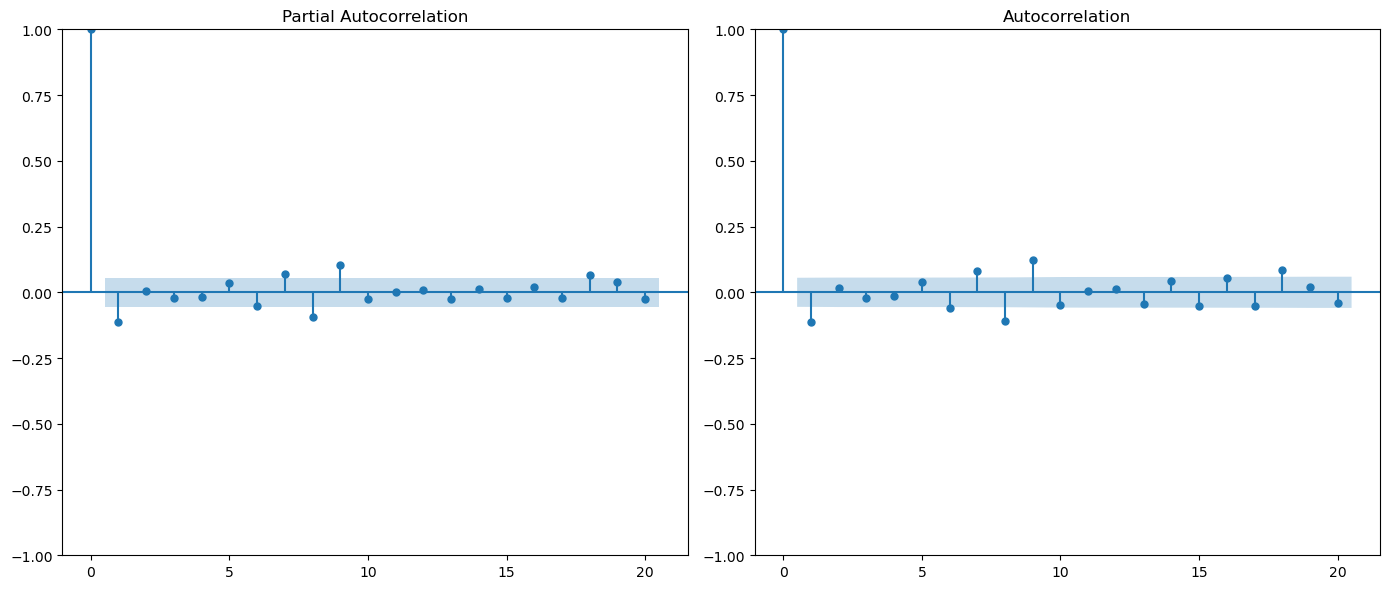

In [5]:
# Plot PACF and ACF
plt.figure(figsize=(14, 6))

# Plot PACF (Partial Autocorrelation)
plt.subplot(1, 2, 1)
plot_pacf(df['Return'], method='ols', lags=20, ax=plt.gca())

# Plot ACF (Autocorrelation)
plt.subplot(1, 2, 2)
plot_acf(df['Return'], lags=20, ax=plt.gca())

plt.tight_layout()
plt.show()

In [6]:
# Rolling window forecasting
y_scaled = df['Return']*100
train_size = 150  # Initial training set size
window_size = 100  # Rolling window size

predictions = []
actual_values = y_scaled[train_size:]  # Test set
history = list(y_scaled[:train_size])  # Initial training data

for i in range(len(actual_values)):
    # Keep only the most recent `window_size` observations
    train_data = np.array(history[-window_size:])  # Ensure NumPy array format for calculations

    # Fit ARIMA model on rolling window
    arima_model = ARIMA(train_data, order=(1, 0, 1)).fit()
    arima_forecast = arima_model.forecast(steps=1)[0]

    # Compute residuals
    residuals = train_data - arima_model.fittedvalues[-window_size:]

    # Fit GARCH model on residuals
    garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
    garch_fitted = garch_model.fit(disp="off")
    
    # Forecast volatility
    garch_forecast = garch_fitted.forecast(horizon=1)
    predicted_volatility = np.sqrt(garch_forecast.variance.iloc[-1, 0])  # Extract latest volatility estimate

    # Adjust ARIMA forecast using GARCH-predicted volatility
    adjusted_forecast = arima_forecast + np.random.normal(0, predicted_volatility)
    predictions.append(adjusted_forecast)  # Store prediction

    # Append actual value to history (simulating real-time update)
    history.append(actual_values.iloc[i])

# Convert predictions list to a Pandas Series for further analysis
predictions = pd.Series(predictions, index=actual_values.index)

In [7]:
# Evaluate model
mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
print("Evaluation Metrics:")
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Create DataFrame for evaluation
df_evaluation = pd.DataFrame({
    'Actual': actual_values,
    'Predict': predictions,
})

Evaluation Metrics:
MAE: 1.8840179904935683, MSE: 6.314232482570238, RMSE: 2.512813658544986


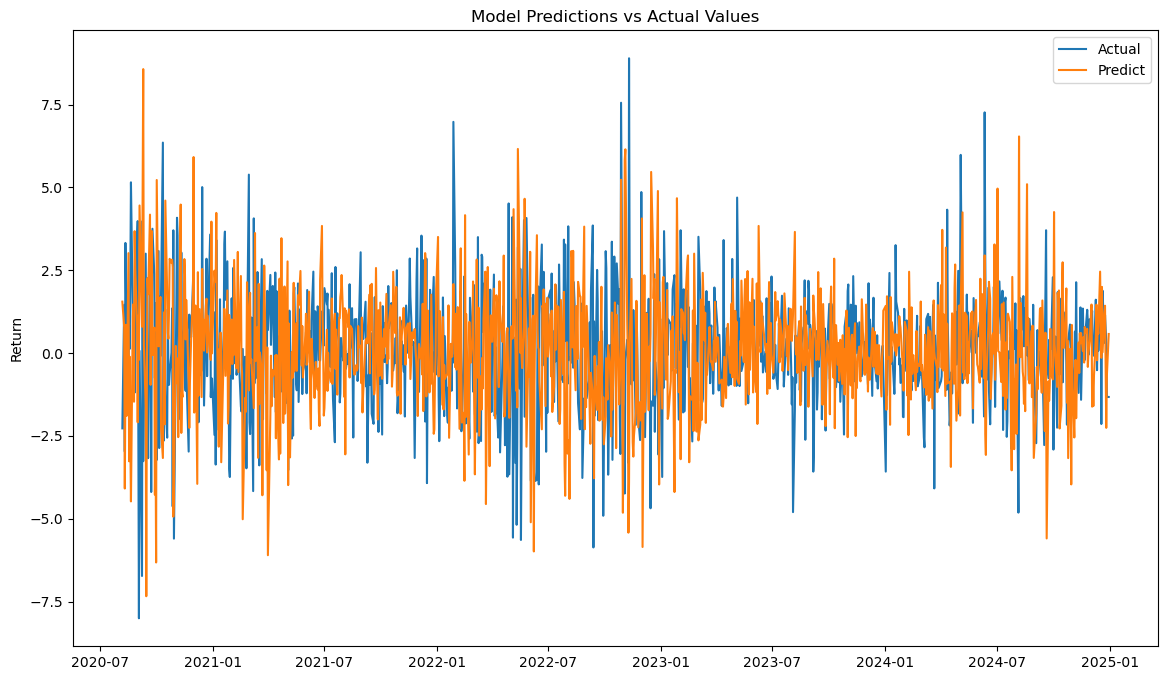

In [8]:
# Visualize predictions vs actual values
plt.figure(figsize=(14, 8))
plt.plot(df_evaluation['Actual'],label='Actual')
plt.plot(df_evaluation['Predict'],label='Predict')
plt.title("Model Predictions vs Actual Values")
plt.ylabel("Return")
plt.legend()
plt.show()

In [9]:
# Backtest trading strategy
def backtest_strategy(predict, price, threshold, transaction_fee, initial_capital):
    capital = initial_capital
    position = 0  # Number of shares held
    portfolio_value = []  # Track portfolio value over time
    trades = []  # Track trades (buy/sell/hold)

    for i in range(len(predict) - 1):
        current_price = price[i]

        # Buy signal: Predicted return >= threshold
        if predict[i + 1] >= threshold and capital >= current_price * (1 + transaction_fee):
            shares = capital // (current_price * (1 + transaction_fee))  
            if shares > 0:  
                position += shares
                capital -= shares * current_price * (1 + transaction_fee)
                trades.append('buy')
            else:
                trades.append('hold')

        # Sell signal: Predicted return <= -threshold
        elif predict[i + 1] <= -threshold and position > 0:
            capital += position * current_price * (1 - transaction_fee)
            position = 0  # Clear position after selling
            trades.append('sell')

        # Hold signal: No action
        else:
            trades.append('hold')

        # Calculate portfolio value at the current time step
        current_value = capital + position * current_price
        portfolio_value.append(current_value)

    return portfolio_value, trades

def buy_and_hold(price, initial_capital):
    shares = initial_capital / price[0]
    portfolio_value = [shares * p for p in price]  # Value over time
    return portfolio_value

In [10]:
df_backtest = df_evaluation.merge(df, left_index=True, right_index=True, how='left')

# Set parameters
initial_balance = 10000
transaction_fee = 0.005
threshold = 3

# Backtest ARIMA model
arima_portfolio_value, arima_trades = backtest_strategy(
    df_backtest['Actual'], df_backtest['Close'], threshold, transaction_fee, initial_balance
)
# Buy and hold
buy_hold_portfolio = buy_and_hold(df_backtest['Close'], initial_balance)

# Create dataframe for graphing
df_backtest = df_backtest.iloc[1:]
df_backtest['Portfolio_Value'] = arima_portfolio_value
df_backtest['Buy_Hold'] = buy_hold_portfolio[1:]

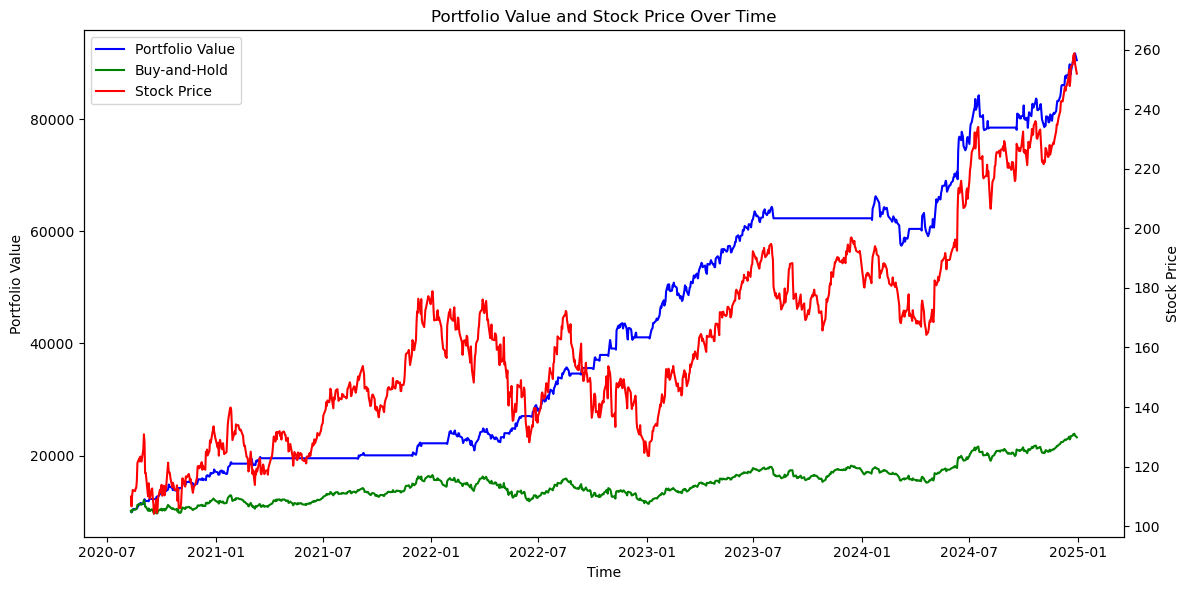

In [11]:
# Visualize portfolio performance

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot portfolio value on the primary y-axis (left)
line1, = ax1.plot(df_backtest['Portfolio_Value'], label='Portfolio Value', color='blue')
line2, = ax1.plot(df_backtest['Buy_Hold'], label='Buy-and-Hold',color='green')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio Value')

# Create a second y-axis for price
ax2 = ax1.twinx()
line3, = ax2.plot(df_backtest['Close'], label='Stock Price', color='red')
ax2.set_ylabel('Stock Price')

# Combine legends from both axes
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')  # Adjust location as needed

# Add title
plt.title('Portfolio Value and Stock Price Over Time')
fig.tight_layout()
plt.show()